# Second Project
## Authors: Bruno Picasso and Jan Frese 

In this project we aim to perform an analysis of the priors for the Covid-19 cases in Chile, during January of 2022. We chose this month because is the one with the biggest incresase of PCR's positivity. For doing the analysis we tried with two different methods. The first one based on Pystan library accordingly to what we have seen in the course and the second method using PYMC based in a Thomas Wiecki youtube video [link](https://www.youtube.com/watch?v=ZxR3mw-Znzc&t=1391s)

In [5]:
import nest_asyncio # para correr Stan en un Jupyter Notebook
nest_asyncio.apply()

import stan 
import pymc as pm
import arviz as az
import seaborn as sns
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
from IPython.display import display, Markdown 
import numpy as np

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

sampler_kwargs = {'chains': 4, 'cores': 4, 'return_inferencedata': True}

In [6]:
# Datos-COVID19/output/producto49/Positividad_Diaria_Media_T.csv
# positivity is casos pcr/pcr
meandpos = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto49/Positividad_Diaria_Media_T.csv')
meandpos['Fecha'] = pd.to_datetime(meandpos['Fecha'], format = '%Y-%m-%d')
meandpos = meandpos[meandpos['Fecha']>'2022-01']
meandpos['pcr'] = meandpos['pcr'].astype(int)
meandpos['casos pcr'] = meandpos['casos pcr'].astype(int)
meandpos['casos ag'] = meandpos['casos ag'].astype(int)

### Gráfico de positividad

In [ ]:
df = meandpos[['Fecha','positividad pcr']]
df.set_index('Fecha', inplace= True)
fig, ax = plt.subplots(figsize = (10,8))
df.plot(ax=ax)
ax.set(ylabel= 'Tasa de Positividad', title = 'Positividad en Chile, 2022')
sns.despine()

### Casos PCR

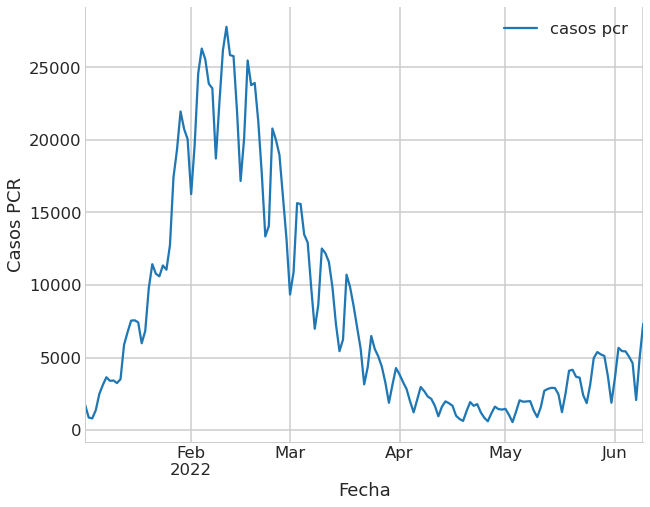

In [7]:
df = meandpos[['Fecha','casos pcr']]
df.set_index('Fecha', inplace= True)
fig, ax = plt.subplots(figsize = (10,8))
df.plot(ax=ax)
ax.set(ylabel= 'Casos PCR')
sns.despine()

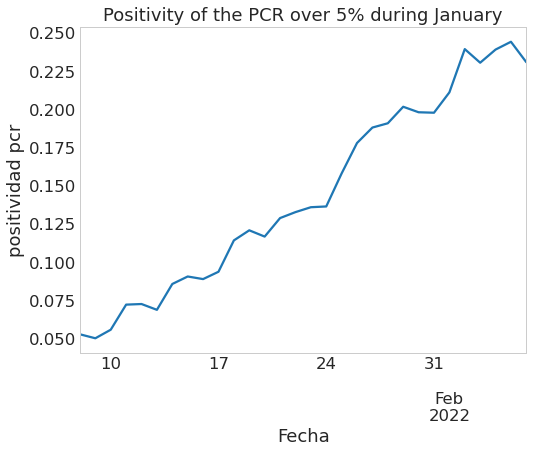

In [8]:
covid_over_5 = meandpos[meandpos['positividad pcr']>=0.05]
ax = covid_over_5.iloc[:30].plot('Fecha', 'positividad pcr', legend=False, figsize=(8,6))
ax.set_ylabel('positividad pcr')
ax.set_title('Positivity of the PCR over 5% during January')
ax.grid()

In [34]:
t = (covid_over_5.iloc[:30]['Fecha'] - covid_over_5['Fecha'].iat[0]).dt.days.values
positivity = covid_over_5.iloc[:30]['positividad pcr'].values
df = pd.DataFrame({'Fecha': j, 'Positividad': positivity})
df.head()

,Fecha,Positividad
0,0,0.0530
1,1,0.0504
2,2,0.0560
3,3,0.0724
4,4,0.0728


In [ ]:
covid_over_5.iloc[:30]['Fecha']

## 2. Build the model

In [ ]:
stan_model = '''
data {
 int<lower = 1 > N;
 vector<lower = 0>[N] j;
 vector<lower = 0>[N] f;
}
parameters {
 real A;
 real b;
 real<lower = 0> error;
}
model {
  //priors
  A ~ normal(0, 100);
  b ~ normal(0.3, 0.3);
  error ~ normal(0, 100);
  
  f ~ normal(A * pow(1+b,j) , error);
}'''

In [ ]:
data_dict = {
    'N' : len(j),
    'j' : j,
    'f' : confirmed 
}

## 3. Run prior predictive check

In [ ]:
prior_stan = '''
generated quantities {
  real f_sim[N];
  real A;
  real b;
  real<lower = 0> error;
  A = normal_rng(0, 100);
  b = normal_rng(0.3, 0.3);
  error = fabs(normal_rng(0, 100));  
  for (i in 1:N){
    f_sim[i] = normal_rng(A * pow(1+b,j[i]), error);
  }
}
'''

In [ ]:
prior_stan_code = stan_model + prior_stan
print(prior_stan_code)

## 4. Fit the model

In [ ]:
prior_stan_code = stan_model + prior_stan
prior_sm = stan.build(stan_model)
prior_fit = prior_sm.sampling(data=meandpos, iter=1000, chains=4, warmup=500, thin=1, seed=101)

## PYMC


/home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Text(0.5, 1.0, 'Prior trend lines')

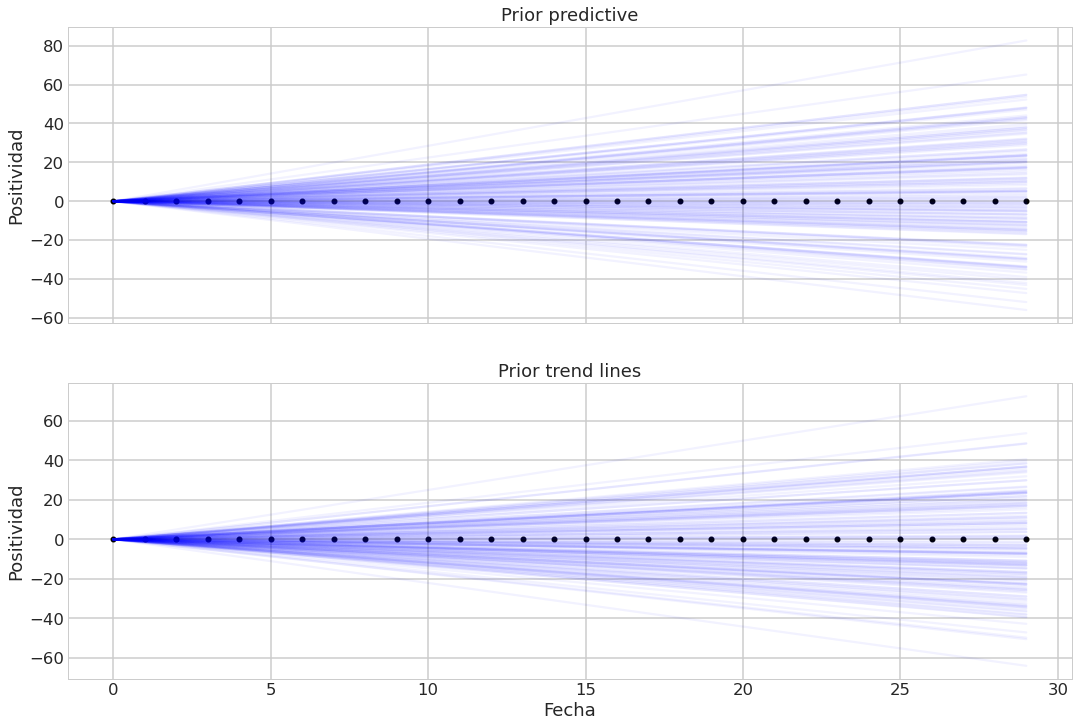

In [29]:
with pm.Model(check_bounds = False) as linear:
    a = pm.HalfNormal('a', 0.01)
    b = pm.Normal('b', 0.01)
    eps = pm.HalfNormal('eps', 0.01)
    trend = pm.Deterministic('trend', a + b*t)

   
    pm.Normal('likelihood', mu = trend, sigma = eps, observed = positivity)

    linear_prior = pm.sample_prior_predictive()

    fig, ax = plt.subplots(nrows= 2, ncols=1, sharex = True, figsize = (18,12))
    ax[0].plot(
        df['Fecha'],
        az.extract_dataset(linear_prior, group = "prior_predictive", num_samples=144)['likelihood'],
        color = "blue",
        alpha = 0.05
    )
    df.plot.scatter(x='Fecha', y='Positividad', color = 'k', ax = ax[0])
    ax[0].set_title('Prior predictive')
    ax[1].plot(
    df["Fecha"],
    az.extract_dataset(linear_prior, group="prior", num_samples=144)["trend"],
    color="blue",
    alpha=0.05
)
df.plot.scatter(x="Fecha", y="Positividad", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")

[Text(0.5, 1.0, 'Prior predictive'),
 Text(0.5, 0, 'Dias de Enero'),
 Text(0, 0.5, 'Positivity')]

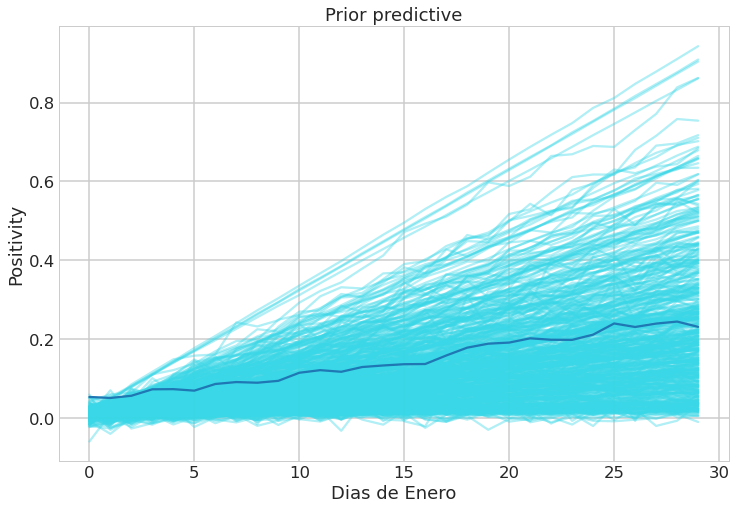

In [12]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(prior_pred['prior_predictive']['obs'][0].T, color = '#39D7E7', alpha = .4)
ax.plot(positivity)
ax.set(title = 'Prior predictive', xlabel = "Dias de Enero", ylabel = 'Positivity')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9535, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'Posterior trend lines')

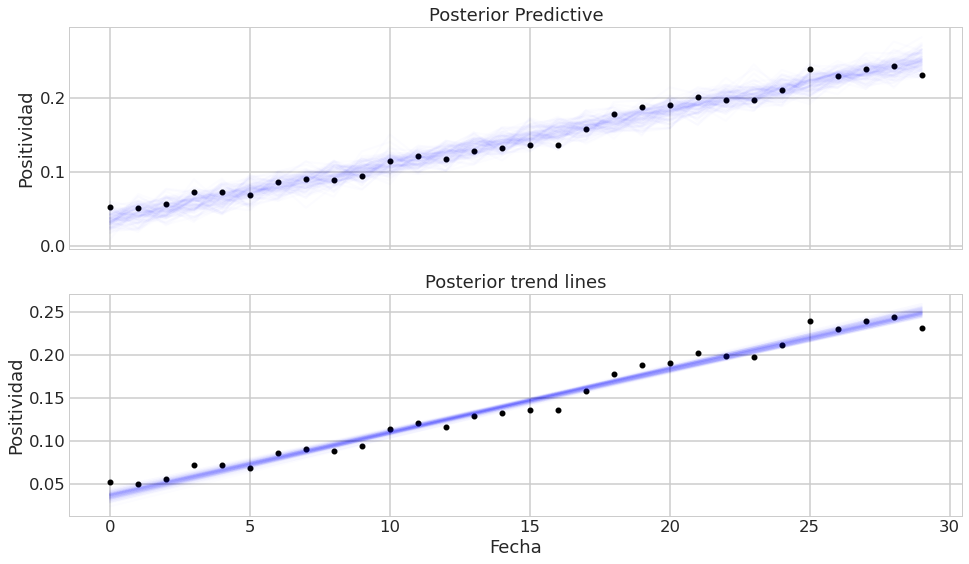

In [31]:
with linear:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_posterior = pm.sample_posterior_predictive(trace = linear_trace)

fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex= True, figsize = (16,9))

ax[0].plot(
    df['Fecha'],
    az.extract_dataset(linear_posterior, group = "posterior_predictive", num_samples=100)['likelihood'],
    color = 'blue',
    alpha = 0.01 
)

df.plot.scatter(x = "Fecha", y = "Positividad", color = 'k', ax = ax[0])
ax[0].set_title('Posterior Predictive')

ax[1].plot(
    df['Fecha'],
    az.extract_dataset(linear_trace, group= 'posterior', num_samples=100)['trend'],
    color = 'blue',
    alpha = 0.01
)
df.plot.scatter(x = 'Fecha', y = 'Positividad', color = 'k', ax = ax[1])
ax[1].set_title('Posterior trend lines')

/home/brunopicasso/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (33), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>],
       [<AxesSubplot:title={'center':'trend\n0'}>,
        <AxesSubplot:title={'center':'trend\n0'}>],
       [<AxesSubplot:title={'center':'trend\n1'}>,
        <AxesSubplot:title={'center':'trend\n1'}>],
       [<AxesSubplot:title={'center':'trend\n2'}>,
        <AxesSubplot:title={'center':'trend\n2'}>],
       [<AxesSubplot:title={'center':'trend\n3'}>,
        <AxesSubplot:title={'center':'trend\n3'}>],
       [<AxesSubplot:title={'center':'trend\n4'}>,
        <AxesSubplot:title={'center':'trend\n4'}>],
       [<AxesSubplot:title={'center':'trend\n5'}>,
        <AxesSubplot:title={'center':'trend\n5'}>],
       [<AxesSubplot:title={'center':'trend\n6'}>,
        <AxesSubplot:title={'center':'trend\n6'}>],
       [

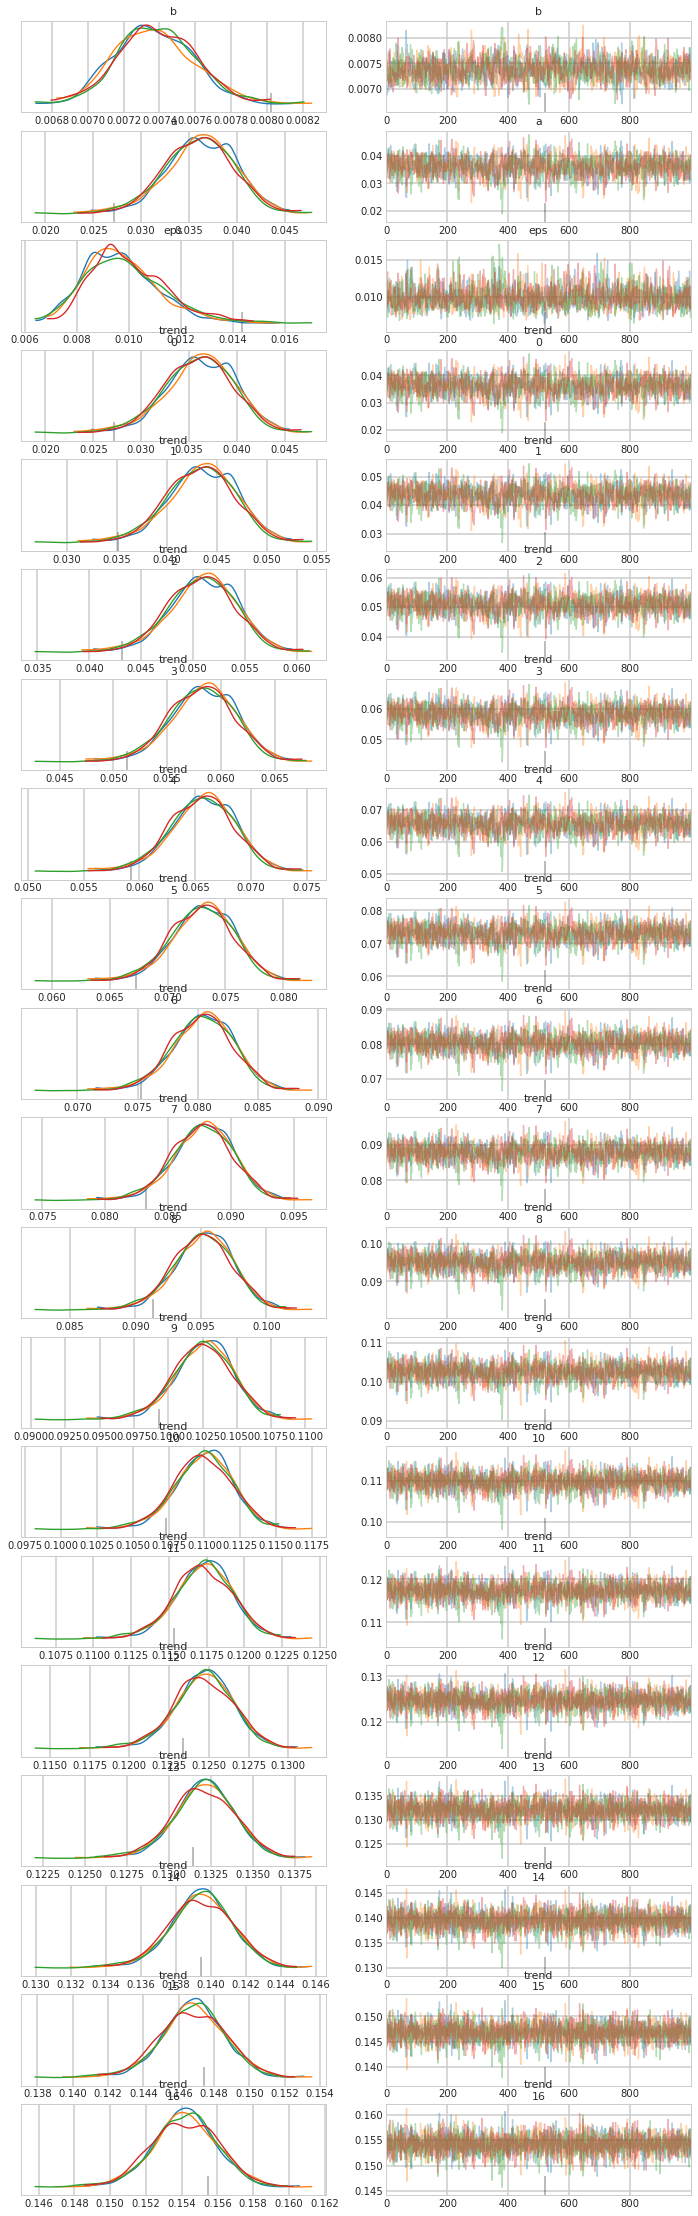

In [35]:
az.plot_trace(linear_trace, compact = False)

In [32]:
az.summary(linear_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.007,0.000,0.007,0.008,0.0,0.0,1008.0,1359.0,1.0
a,0.036,0.004,0.029,0.043,0.0,0.0,1027.0,1270.0,1.0
eps,0.010,0.001,0.007,0.013,0.0,0.0,1356.0,1615.0,1.0
trend[0],0.036,0.004,0.029,0.043,0.0,0.0,1027.0,1270.0,1.0
trend[1],0.043,0.003,0.037,0.050,0.0,0.0,1044.0,1247.0,1.0
trend[2],0.051,0.003,0.045,0.057,0.0,0.0,1063.0,1308.0,1.0
trend[3],0.058,0.003,0.052,0.064,0.0,0.0,1089.0,1316.0,1.0
trend[4],0.066,0.003,0.060,0.071,0.0,0.0,1122.0,1341.0,1.0
trend[5],0.073,0.003,0.068,0.078,0.0,0.0,1171.0,1515.0,1.0
trend[6],0.080,0.003,0.076,0.085,0.0,0.0,1246.0,1561.0,1.0
